# Decision Tree

决策树是基于树结构来进行决策的，类似人在面临决策问题时一种很自然的处理机制。下图是一个决策树的例子，关于女孩决定是否去相亲：
![女孩决定是否去相亲决策树](images/image01.png)

一棵决策树包含一个根结点、若干个内部结点和若干个叶结点；叶结点对应于决策结果，其他每个结点则对应于一个属性测试；每个结点包含的样本集合根据属性测试的结果被划分到子结点中；根结点包含样本全集。从根结点到每个叶结点的路径对应了一个判定序列。使用决策树进行决策的过程就是从根结点开始，测试待分类项中相应的特征属性，并按照其值选择输出分支，直到到达叶子结点，将叶子结点存放的类别作为决策结果。

## 生成决策树

决策树算法的伪代码：

输入： 训练集 $D = \{(x_1, y_1),(x_2, y_2),\cdots,(x_m, y_m)\}$；
     属性集 $A = \{a_1, a_2,\cdots,a_m\}$。

过程：函数generate_tree(D, A)

```pascal
生成结点 node；
if D 中样本全属于同一类别C then
    将 node 标记为C类叶结点；return
end if
if A = 空集 then
    将 node 标记为叶结点，其类别标记为D中样本数最多的类；return
end if
从A中选择最优划分属性a；
for a 的每一个值 v do
    为 node 生成一个分支；令D_v表示D中在a上取值v的样本子集
    if D_v 为空 then
        将分支结点标记为叶结点，其类别标记为D中样本最多的类；return
    else
        以 generate_tree(D_v, A \ {a})为分支结点
    end if
end for
```

输出：以 node 为根结点的一棵决策树。


在从A中选择最优划分属性a中，根据策略的不同，决策树可以分为ID3、C4.5和CART。


首先，我们来定义决策树使用的数据类型：结点。结点分为内部结点和叶子结点。

In [1]:
import sys
import math
import copy
import json
import numpy as np
import matplotlib.pyplot as plt

class Node(object):
    """
    结点的父类
    """
    def __init__(self):
        self.train_classes_num = None  # 训练集类分布
        self.val_classes_num = None  # 验证集类分布
        self.data_info = None  # 训练集信息

class InternalNode(Node):
    """
    内部结点
    """
    def __init__(self):
        super().__init__()
        self.feature = None  # 属性名称
        self.axis = None  # 属性在训练集中的位置
        self.branch = []  # 结点的分支
        self.feature_values = [] # 属性的取值，位置与branch对应
        
    def __str__(self):
        print_str = "{" + "\"" + self.feature + "\"" + ": {"
        for i in range(len(self.branch)):
            print_str += str("\"" + self.feature_values[i] + "\"" + ": " + str(self.branch[i])) + ", "
        print_str = print_str[:-2]
        print_str += "}}"
        return print_str
    

class LeafNode(Node):
    """
    叶子结点
    """
    def __init__(self):
        super().__init__()
        self.class_label = None  # class label
        #self.val_set = []  # 保存验证集样本

    def __str__(self):
        return "\"" + self.class_label + "\""
    

分析函数`generate_tree`，我们需要一个函数`get_max_num_class`来获取训练集中数量最多的类，需要函数`split_data_set`来划分训练集，需要函数`get_best_feature`来选择最优划分属性，需要函数`count_values`统计属性或类别标签在训练集中的值的分布。我们接下来实现这4个函数。

**任务1：**实现`get_max_num_class`函数。

In [2]:
def get_max_num_class(classes_num):
    """
    获取数量最多的类
    参数：
        classes_num: 类别标签的分布，比如[1,0,2,3]
    返回：
        数量最多的类的位置
    """
    
    cls = None
    
    ### START CODE HERE ###
    cls=classes_num.index(max(classes_num))
    
    ### END CODE HERE ###
    
    return cls

In [3]:
test = [1,0,2,3]
print(get_max_num_class(test))

3


**任务2：**实现`split_data_set`函数。

In [4]:
def split_data_set(data_set, axis, value, is_delete_axis=True):
    """
    在训练集的axis列，选择值为value的训练集样本，并返回
    参数：
        data_set: 训练集
        axis： 属性所在列
        value： 属性的所取的值
        is_delete_axis: 是否删除第axis列
    返回：
        划分的子训练集
    """
    sub_data_set = []
    ### START CODE HERE ###
    for sample in data_set:
        if sample[axis] == value:
            if is_delete_axis:
                # 删除第axis列并把sample保存到sub_data_set中
                axisSample =  sample[:axis]                #去掉axis特征
                axisSample.extend(sample[axis+1:])     #将符合条件的添加到返回的数据集
                sub_data_set.append(axisSample)
            else:
                # 把sample保存到sub_data_set中
                sub_data_set.append(sample)
                

    ### END CODE HERE ###
    return sub_data_set

In [5]:
test = [[1,1],[1,2],[2,3],[2,1],[3,2],[3,3]]
print(split_data_set(test, 0, 2))

[[3], [1]]


函数`count_values`统计数据集中某一列的值的分布。

**任务3：**实现`count_values`函数。

In [6]:
def count_values(data_set, axis, values):
    """
    统计values在数据集中第axis列出现的个数
    参数：
        data_set: 数据集
        axis: 位置
        values: 统计的值
    """
    ### START CODE HERE ###

    value_list = [sample[axis] for sample in data_set]
    values_num = []
    for i in range(len(values)):
        # 统计特征值values【i】出现的次数
        count=0
        for label in value_list:
            if label == values[i]:
                count = count+1
        values_num.append(count)
    ### END CODE HERE ###
    return values_num

In [7]:
test =  [[1,1],[1,2],[2,3],[2,1],[3,2],[3,3]]
print(count_values(test, -1, [1,2,3]))

[2, 2, 2]


函数`get_best_feature`选择最优划分属性，有许多划分策略，现在实现一个简单的策略：选择属性集中第一个属性。

In [8]:
def get_best_feature(data_set, features, data_info):
    """
    根据某种策略选择最优划分属性
    这里选择第一个属性
    参数：
        data_set: 训练集
        features： 属性集
        data_info: 保存完整属性集的信息，{features:[], features_values={feature1:[], ... }, classes:[]}
    返回：
        选择的属性的位置axis
    """
    return 0

**任务4：**实现`generate_tree`函数。

In [9]:
def generate_tree(data_set, features, get_best_feature, data_info):
    """
    生成决策树
    参数：
        data_set: 训练集，最后一列是类别标签，其他是属性eatures
        features: 属性集
        get_best_feature: 选择最优划分属性的函数
        data_info: 保存完整属性集的信息，{features:[], features_values={feature1:[], ... }, classes:[]}
    返回：
        决策树的结点
    """
    assert len(data_set) != 0, "the size of data set cannot be 0"
    
    features = features[:]
    
    classes_num = count_values(data_set, -1, data_info["classes"])
    val_classes_num = [0 for i in classes_num]
    
    class_list = [sample[-1] for sample in data_set]
    
    ### START CODE HERE ###
    
    # 如果训练集的样本都属于同一类，返回类别标记为这个类的叶子结点
    if len(set(class_list)) == 1:
        node = LeafNode()
        node.data_info = data_info
        node.class_label = data_info["classes"][get_max_num_class(classes_num)]
        node.train_classes_num = classes_num
        node.val_classes_num = val_classes_num
        return node

    # 如果属性集为空，返回类别标记为训练集中数量最多的类的叶子结点
    if len(features) == 0:
        node = LeafNode()
        node.data_info = data_info
        node.class_label = data_info["classes"][get_max_num_class(classes_num)]
        node.train_classes_num = classes_num
        node.val_classes_num = val_classes_num
        return node

    node = InternalNode()
    node.data_info = data_info
    node.train_classes_num = classes_num
    node.val_classes_num = val_classes_num
    # 选择最优划分属性a
    axis = get_best_feature(data_set, features, data_info)
    best_feature = features[axis]
    node.feature = best_feature
    node.axis = data_info["features"].index(best_feature)
    del features[axis]

    feature_values = data_info["features_values"][best_feature]
    node.feature_values = feature_values
    # 根据属性a取值划分训练集
    for feature_value in feature_values:
        sub_data_set = split_data_set(data_set, axis, feature_value)
        if len(sub_data_set) == 0:
            sub_node = LeafNode()
            sub_node.data_info = data_info
            sub_node.class_label = data_info["classes"][get_max_num_class(classes_num)]
            sub_node.train_classes_num = count_values(sub_data_set, -1, data_info["classes"])
            sub_node.val_classes_num = val_classes_num
            node.branch.append(sub_node)
        else:
            # 为子集生成决策树
            node.branch.append(generate_tree(sub_data_set, features, get_best_feature, data_info))

    ### END CODE HERE ###
    return node

已经完成了函数`generate_tree`，让我们导入数据并生成一个决策树。我们使用的数据来自[http://archive.ics.uci.edu/ml/datasets/Balance+Scale](http://archive.ics.uci.edu/ml/datasets/Balance+Scale)。该数据用来模拟心理学实验结果，它的一条记录为：

1. Class Name: 3 (L, B, R) 
2. Left-Weight: 5 (1, 2, 3, 4, 5) 
3. Left-Distance: 5 (1, 2, 3, 4, 5) 
4. Right-Weight: 5 (1, 2, 3, 4, 5) 
5. Right-Distance: 5 (1, 2, 3, 4, 5)

分类的正确方法是选择$\text{Left-Weight} \times \text{Left-Distance}$和$\text{Right-Weight} \times \text{Right-Distance}$中的较大者。如果相等，那么类别为B。

In [10]:
with open("balance-scale.data", "r") as file:
    content = file.read()

row_list = content.splitlines()
data_set = [row.split(",") for row in row_list if row.strip()]
# 调整类别标签和属性的位置
for sample in data_set:
    class_label = sample.pop(0)
    sample.append(class_label)

features = ["LW", "LD", "RW", "RD"]
feature_values = ["1", "2", "3", "4", "5"]
features_values = {"LW": feature_values, "LD": feature_values, "RW": feature_values, "RD": feature_values}
classes = ["L", "B",  "R"]
data_info = {"features": features, "features_values": features_values, "classes": classes}

# 使用训练集的前10个样本进行训练
for i in data_set[:10]:
    print(i)
    
decision_tree = generate_tree(data_set[:10], features, get_best_feature, data_info)
print(json.dumps(eval(str(decision_tree)), sort_keys=True, indent=2))

['1', '1', '1', '1', 'B']
['1', '1', '1', '2', 'R']
['1', '1', '1', '3', 'R']
['1', '1', '1', '4', 'R']
['1', '1', '1', '5', 'R']
['1', '1', '2', '1', 'R']
['1', '1', '2', '2', 'R']
['1', '1', '2', '3', 'R']
['1', '1', '2', '4', 'R']
['1', '1', '2', '5', 'R']
{
  "LW": {
    "1": {
      "LD": {
        "1": {
          "RW": {
            "1": {
              "RD": {
                "1": "B",
                "2": "R",
                "3": "R",
                "4": "R",
                "5": "R"
              }
            },
            "2": "R",
            "3": "R",
            "4": "R",
            "5": "R"
          }
        },
        "2": "R",
        "3": "R",
        "4": "R",
        "5": "R"
      }
    },
    "2": "R",
    "3": "R",
    "4": "R",
    "5": "R"
  }
}


可以看到，先前实现的`get_best_feature`使用的选择最优划分属性策略不好，生成的决策树太复杂。因此，需要选择好的策略。

## ID3

熵(entropy)：信息量大小的度量，即表示随机变量不确定性的度量。

事件$a_i$的信息量$I(a_i)$可如下度量：$I(a_i) = -p(a_i) \log p(a_i)$，这里$p(a_i)$为事件$a_i$发生的概率。

假设有n个互不相容的事件$a_i, \cdots, a_n$，它们中有且仅有一个发生，则其平均的信息量（熵）可如下度量：
$$
I(a_i, \cdots, a_n) = \sum_{i} I(a_i) = - \sum_{i} p(a_i) \log p(a_i)
$$

假设当前训练集D中第k类样本比例为$p_k$，对应的信息熵为：
$$
\text{Ent}(D) = - \sum_k p_k \log p_k
$$

$\text{Ent}(D)$越小，表示数据越有序，纯度越高，分类效果越好。

假设某离散属性a有V个可能值，若采用该属性对样本集来划分，则会产生V个分支，每个分支节点包含的数据记为$D^v$。用属性a对训练集D进行划分，获得的信息增益为：
$$
\text{Gain}(D, a) = \text{Ent}(D) - \sum_v \frac{|D^v|}{|D|} \text{Ent}(D^v)
$$

ID3选择具有最大信息增益的属性来划分：$a* = \arg \underset{a}{\max} \text{Gain}(D, a)$。

接下来实现ID3版本的选择最优划分属性函数`get_best_feature_id3`。首先实现计算训练集信息熵函数`compute_entropy`。

**任务5：**实现`compute_entropy`函数。

In [11]:
def compute_entropy(values_num):
    """
    根据变量的分布values_num计算信息熵
    参数：
        values_num: 变量的分布
    返回：
        信息熵
    """
    
    ### START CODE HERE ###
    
    m = float(sum(values_num))
    entropy = 0
    for value_num in values_num:
        if value_num == 0:  # 不能计算 log(0)
            continue
        prob =  value_num / m
        entropy -= prob * np.log(prob)

    ### END CODE HERE ###
    return entropy

In [12]:
test = [1,2,3]
print(compute_entropy(test))

1.0114042647073518


**任务6：**实现`get_best_feature_id3`函数。

In [13]:
def get_best_feature_id3(data_set, features, data_info):
    """
    根据信息增益选择划分属性
    参数：
        data_set: 训练集
        features： 属性集
        data_info: 保存完整属性集的信息，{features:[], features_values={feature1:[], ... }, classes:[]}
    返回：
        选择的属性的位置axis
    """
    
    ### START CODE HERE ###
    
    # 计算训练集的信息熵
    m = len(data_set)
    classes_num = count_values(data_set, -1, data_info["classes"])
    entropy = compute_entropy(classes_num)

    gain = 0
    best_axis = 0
    # 计算按照属性a的取值划分训练集后的信息熵
    for i in range(len(features)):
        split_entropy = 0
        feature_values = data_info["features_values"][features[i]]
        for feature_value in feature_values:
            sub_data_set = split_data_set(data_set, i, feature_values, is_delete_axis=True)
            sub_classes_num = count_values(data_set,  -1, data_info["classes"])
            inforS = len(sub_data_set) * 1.0
            split_entropy +=  compute_entropy(sub_classes_num) * inforS / m
        if entropy - split_entropy > gain:
            gain = entropy - split_entropy
            best_axis = i

    ### END CODE HERE ###
    return best_axis

In [14]:
# 使用训练集的前10个样本进行训练
for i in data_set[:10]:
    print(i)
    
id3_tree = generate_tree(data_set[:10], features, get_best_feature_id3, data_info)
print(json.dumps(eval(str(id3_tree)), sort_keys=True, indent=2))

['1', '1', '1', '1', 'B']
['1', '1', '1', '2', 'R']
['1', '1', '1', '3', 'R']
['1', '1', '1', '4', 'R']
['1', '1', '1', '5', 'R']
['1', '1', '2', '1', 'R']
['1', '1', '2', '2', 'R']
['1', '1', '2', '3', 'R']
['1', '1', '2', '4', 'R']
['1', '1', '2', '5', 'R']
{
  "LW": {
    "1": {
      "LD": {
        "1": {
          "RW": {
            "1": {
              "RD": {
                "1": "B",
                "2": "R",
                "3": "R",
                "4": "R",
                "5": "R"
              }
            },
            "2": "R",
            "3": "R",
            "4": "R",
            "5": "R"
          }
        },
        "2": "R",
        "3": "R",
        "4": "R",
        "5": "R"
      }
    },
    "2": "R",
    "3": "R",
    "4": "R",
    "5": "R"
  }
}


可以看到，ID3生成的决策树比之前生成的决策树要简单得多。现在可以使用生成的决策树对新样本进行分类。

**任务7：**实现决策树的推理函数`inference`。

In [15]:
def inference(tree, sample, is_add_to_node=False):
    """
    对新样本进行分类
    参数：
        sample: 新样本
        is_add_to_node: 是否把新样本类别信息放到结点中
    返回：
        新样本的分类结果
    """
    node = tree
    classes = tree.data_info["classes"]
    if is_add_to_node:
        node.val_classes_num[classes.index(sample[-1])] += 1
        
    ### START CODE HERE ###
    
    while type(node) == InternalNode:
        for i in range(len(node.feature_values)):
            if node.feature_values[i] == sample[node.axis]:
                node = node.branch[i]
                break
    
    ### END CODE HERE ###
    return node.class_label

In [16]:
class_label = inference(id3_tree, data_set[0], data_info)
print(class_label)

B


## C4.5

ID3算法的基本思想是以信息增益选择属性，实际应用中会对可能取值数目较多的属性有所偏好。例如，如果对每个训练样本进行编号，并将编号作为属性，其信息增益最大，但显然该属性不能作为分类依据。因此，C4.5算法使用信息增益比来选择划分属性。

信息增益比公式如下：
$$
\text{Gain_ratio}(D, a) = \frac{\text{Gain}(D,a)}{\text{IV}(a)}
$$
其中
$$
\text{IV}(a) = - \sum_{v=1}^V \frac{|D^v|}{|D|} \log \frac{|D^v|}{|D|}
$$
是属性a的固定值(intrinsic value)，a可能的取值越多，$\text{IV}(a)$通常也越大。

接下来实现C4.5版本的选择最优划分属性函数`get_best_feature_c45`。在这里不设置信息增益比的阈值$\epsilon$，直接选择具有最大信息增益比的属性。

**任务8：**实现`get_best_feature_c45`函数。

In [17]:
def get_best_feature_c45(data_set, features, data_info):
    """
    根据信息增益率选择划分属性
    参数：
        data_set: 训练集
        features： 属性集
        data_info: 保存完整属性集的信息，{features:[], features_values={feature1:[], ... }, classes:[]}
    返回：
        选择的属性的位置axis
    """
    ### START CODE HERE ###
    
    # 计算训练集的信息熵
    m = len(data_set)
    classes_num = count_values(data_set, -1, data_info["classes"])
    entropy = compute_entropy(classes_num)

    gain_ratio = 0
    best_axis = 0
    # 计算按照属性a的取值划分训练集后的信息熵
    for i in range(len(features)):
        split_entropy = 0
        gain = 0
        feature_values_num = count_values(data_set, i, data_info["features_values"][features[i]])
        # iv + 1e-7 防止分母为0
        iv = compute_entropy(feature_values_num) + 1e-7
        feature_values = data_info["features_values"][features[i]]
        for feature_value in feature_values:
            sub_data_set = split_data_set(data_set, i, feature_value)
            sub_classes_num = count_values(sub_data_set, -1, data_info["classes"])
            inforS = len(sub_data_set)
            split_entropy += compute_entropy(sub_classes_num) * inforS / m
        gain = entropy - split_entropy
        if gain / iv > gain_ratio:
            gain_ratio = gain / iv
            best_axis = i

    ### END CODE HERE ###
    return best_axis

In [18]:
# 使用训练集的前10个样本进行训练
for i in data_set[:10]:
    print(i)
    
c45_tree = generate_tree(data_set[:10], features, get_best_feature_c45, data_info)
print(json.dumps(eval(str(c45_tree)), sort_keys=True, indent=2))

['1', '1', '1', '1', 'B']
['1', '1', '1', '2', 'R']
['1', '1', '1', '3', 'R']
['1', '1', '1', '4', 'R']
['1', '1', '1', '5', 'R']
['1', '1', '2', '1', 'R']
['1', '1', '2', '2', 'R']
['1', '1', '2', '3', 'R']
['1', '1', '2', '4', 'R']
['1', '1', '2', '5', 'R']
{
  "RD": {
    "1": {
      "RW": {
        "1": "B",
        "2": "R",
        "3": "B",
        "4": "B",
        "5": "B"
      }
    },
    "2": "R",
    "3": "R",
    "4": "R",
    "5": "R"
  }
}


因为数据简单，C4.5生成的决策树和ID3生成的决策树一样。

## 决策树的剪枝

通常生成的决策树复杂度非常高，过度拟合训练数据，导致过拟合，决策树的剪枝减少决策树的规模，是处理过拟合问题的主要手段。

通过极小化决策树整体的 Cost Complexity 函数实现剪枝
$$
\text{CC}(T) = \text{Err}(T) + \lambda R(T)
$$
其中$\text{Err}(T)$为树T的错误，$R(T)$为正则化项，描述树的复杂度（如树节点的个数），$\lambda \ge 0$为正则化参数。

设树T的叶结点个数为$|T|$，t是树T的叶结点，该叶结点有$N_t$个样本点，其中k类的样本点有$N_{tk}$个，$k=1,2,\cdots,K$。叶结点t上的信息熵：
$$
H_t(T) = - \sum_{k=1}^K \frac{N_{tk}}{N_t} \log \frac{N_{tk}}{N_t} 
$$
$\text{Err}(T)$为
$$
\text{Err}(T) = \sum_{i=1}^{|T|} N_t H_t(T) = - \sum_{i=1}^{|T|} \sum_{k=1}^K N_{tk} \log \frac{N_{tk}}{N_t}
$$
则
$$
\text{CC}(T) = - \sum_{i=1}^{|T|} \sum_{k=1}^K N_{tk} N_{tk} \log \frac{N_{tk}}{N_t}  + \lambda |T|
$$

决策树的剪枝算法：

- 输入：算法产生的整个决策树T，正则化参数$\lambda$
- 输出：修剪后的决策树T
    - Step 1: 计算每个结点的代价
    - Step 2: 递归地从树的叶结点向上回溯
- 设一组叶结点回溯到其父结点之前与之后的代价分别为：$\text{CC}(T_B)$和$\text{CC}(T_A)$，若$\text{CC}(T_A) \le \text{CC}(T_B)$，则剪枝，返回Step 2，直到不能继续为止。
- 注意是根据验证集上的代价来决定是否剪枝。

**任务9：**下面我们来实现计算 Cost Complexity 的函数`compute_tree_cc`。

In [19]:
def compute_tree_cc(tree, lambd=1):
    """
    计算决策树的 Cost Complexity 值
    参数：
        tree: 决策树
        lambd: 正则化参数
    返回：
        决策树的 Cost Complexity 值
    """
    ### START CODE HERE ###
    
    err = 0
    leaf_count = 0
    node_list = [tree]
    while len(node_list) != 0:
        node = node_list.pop(0)
        if type(node) == InternalNode:
            for i in node.branch:
                node_list.append(i)
        else:
            Nt = sum(node.val_classes_num)
            ent = compute_entropy(node.val_classes_num)
            err += ent * Nt
            leaf_count += 1
    
    return err + lambd * leaf_count

    ### END CODE HERE ###

In [20]:
print(compute_tree_cc(c45_tree))

9


**任务10：**实现决策树的剪枝函数`pruning`。

In [21]:
def pruning(tree, p, node, lambd = 1):
    """
    剪枝决策树
    参数：
        tree: 决策树
        p: 父结点
        node: 正在遍历的结点
        lambd: 正则化参数
    返回：
        处理后的结点
    """
    if type(node) == LeafNode:
        return node
    # 后序遍历
    for i in range(len(node.branch)):
        node.branch[i] = pruning(tree, node, node.branch[i], lambd)
    
    can_pruning = True
    for i in node.branch:
        if type(i) == InternalNode:
            can_pruning = False
            break
    
    if can_pruning:
        CC_before = compute_tree_cc(tree, lambd)
        CC_after = None
        ### START CODE HERE ###
        
        # 内部结点转叶子结点
        leaf_node = LeafNode()
        leaf_node.train_classes_num = node.train_classes_num
        leaf_node.val_classes_num = node.val_classes_num
        leaf_node.data_info = node.data_info
        classes = node.data_info["classes"]
        classes_num = node.train_classes_num
        leaf_node.class_label = classes[get_max_num_class(classes_num)]
        
        if tree == node:
            CC_after = compute_tree_cc(leaf_node, lambd)
        else:
            index = p.branch.index(node)
            p.branch[index] = leaf_node
            CC_after = compute_tree_cc(tree, lambd)
            
        if CC_after <= CC_before:
            return leaf_node
        else:
            return node
        
        ### END CODE HERE ###
    else:
        return node

In [22]:
# 划分训练集和验证集
m = len(data_set)
m_train = int(m*0.7)
m_val = m - m_train
data_train = data_set[:m_train]
data_val = data_set[m_train:]
classes_label_val = [sample[-1] for sample in data_val]

c45_tree_before = generate_tree(data_train, features, get_best_feature_c45, data_info)
print("剪枝前：")
#print(json.dumps(eval(str(c45_tree_before)), sort_keys=True, indent=2))

predict = []
for sample in data_val:
    predict.append(inference(c45_tree_before, sample, is_add_to_node=True))

is_same = [1 if classes_label_val[i] == predict[i] else 0 for i in range(m_val)]
accuracy = sum(is_same) / m_val
print("the accuracy before pruning is %.3f" % accuracy)

# 剪枝
c45_tree_after = pruning(c45_tree_before, None, c45_tree_before, lambd=1)
print("剪枝后：")
#print(json.dumps(eval(str(c45_tree_after)), sort_keys=True, indent=2))

predict = []
for sample in data_val:
    predict.append(inference(c45_tree_after, sample, is_add_to_node=False))

is_same = [1 if classes_label_val[i] == predict[i] else 0 for i in range(m_val)]
accuracy = sum(is_same) / m_val
print("the accuracy before pruning is %.3f" % accuracy)

剪枝前：
the accuracy before pruning is 0.606
剪枝后：
the accuracy before pruning is 0.532


## CART

CART(Classification and Regression Tree)算法是目前决策树算法中最为成熟的一类算法，它既可以用于分类（CART决策树），又可以用于预测（CART回归树）。

CART决策树与ID3、C4.5的不同之处在于CART决策树是一棵二叉树，使用基尼系数（Gini Index）来选择划分属性。

基尼值的计算公式为：
$$
\text{Gini}(D) = \sum_{k=1}^{K} \sum_{k' \not = k} p_k p_{k'} = 1 - \sum_{k=1}^K p_k^2
$$

直观上，基尼值反应了从数据集中任选2个样本，其类别不一致的概率，其值越小，纯度越高。

基尼系数的计算公式为：
$$
\text{Gini_index}(D, a) = \sum_{v=1}^V \frac{|D^v|}{|D|} \text{Gini}(D^v)
$$

CART决策树使用的是离散值的属性，如果样本的属性是连续型的，需要使用离散化方法把连续属性离散化。

CART决策树生成算法：

- 输入：训练数据集D，迭代终止条件
- 输出：CART决策树
- 从根结点开始，递归对每个结点进行以下操作构造二叉树
    - 设结点数据集为D，对每个特征A，对其每个值a，根据样本点对$A=a$的测试为是或否，将D分为$D^-$,$D^+$，计算$A=a$的基尼系数
    - 在所有的特征A以及所有可能的切分点a中，选择基尼指数最小的特征和切分点，将数据集分配到两个子结点中
    - 对两个子结点递归调用上面两个步骤，最终生成CART决策树
    
下面开始实现CART决策树，我们需要`compute_gini`计算基尼值，`compute_gini_index`计算基尼系数。

**任务11：**实现`compute_gini`函数。

In [23]:
def compute_gini(class_num):
    """
    计算基尼值
    参数：
        class_num: 类别的分布信息
    返回：
        基尼值
    """
    ### START CODE HERE ###
    gini = 0
    m = float(sum(class_num))
    for i in class_num:
        if i != 0:
            prob = i / m
            gini += prob ** 2
    return 1 - gini
    ### END CODE HERE ###

In [24]:
test = [1, 2, 3]
print(compute_gini(test))

0.6111111111111112


**任务12：**实现`compute_gini_index`函数。

In [25]:
def compute_gini_index(data_set, axis, value, data_info):
    """
    计算(D, a)基尼系数
    参数：
        data_set: 训练集
        axis: 属性位置
        value: 选取的属性值
        data_info: 保存完整属性集的信息，{features:[], features_values={feature1:[], ... }, classes:[]}
    返回：
        基尼系数
    """
    m = len(data_set)
    
    classes = data_info["classes"]
    
    feature = data_info["features"][axis]
    feature_values = data_info["features_values"][feature]
    
    values_num = count_values(data_set, axis, feature_values)
    
    value_index = feature_values.index(value)
    value_count = values_num[value_index]
    others_count = m - value_count
    ### START CODE HERE ###
    # compute gini of value
    sub_data_set = split_data_set(data_set, axis, value, is_delete_axis=False)
    value_gini = compute_gini(count_values(sub_data_set, -1, data_info["classes"]))
    
    # compute gini of others
    sub_data_set = []
    for feature_value in feature_values:
        if feature_value == value:
            continue
        sub_data_set.extend(split_data_set(data_set, axis, feature_value, is_delete_axis=False))
    others_gini = compute_gini(count_values(sub_data_set, -1, data_info["classes"]))
    
    return  (value_gini * value_count + others_gini * others_count) / m

    ### END CODE HERE ###

In [26]:
test = [
    [1, 1, 1],
    [1, 2, 2],
    [2, 1, 1],
    [2, 2, 2]
]

test_data_info = {
    "features": [1, 2],
    "features_values": {1: [1, 2], 2: [1, 2]},
    "classes": [1, 2]
}

for i in range(2):
    for j in range(1, 3):
        print(compute_gini_index(test, i, j, test_data_info))

0.5
0.5
0.0
0.0


函数`get_best_feature_cart_decision`用于获取基尼系数最小的属性和切分点。

**任务13：**实现`get_best_feature_cart_decision`函数。

In [27]:
def get_best_feature_cart_decision(data_set, data_info):
    """
    根据基尼系数选择最优划分属性和切分点
    参数：
        data_set: 训练集
        data_info: 保存完整属性集的信息，{features:[], features_values={feature1:[], ... }, classes:[]}
    返回：
        (axis, vlaue): 属性位置，切分点值
    """
    m = len(data_set)
    
    lowest_gini_index = 1
    axis = 0
    value = None
    
    classes = data_info["classes"]
    
    features = data_info["features"]
    ### START CODE HERE ###
    for i in range(len(features)):
        feature = features[i]
        gini_index = 0
        
        feature_values = data_info["features_values"][feature]
        values_num = count_values(data_set, i, feature_values)
        # 该属性在data_set中只有一个值，不能把数据分成两部分
        if m in values_num:
            continue
        
        for j in range(len(feature_values)):
            if values_num[j] == 0:
                continue
            gini_index = compute_gini_index(data_set, i, feature_values[j], data_info)
            
            if gini_index < lowest_gini_index:
                lowest_gini_index = gini_index
                axis = i
                value = feature_values[j]
    
    ### END CODE HERE ###
    return (axis, value)

In [28]:
test = [
    [1, 1, 1],
    [1, 2, 2],
    [2, 1, 1],
    [2, 2, 2]
]

test_data_info = {
    "features": [1, 2],
    "features_values": {1: [1, 2], 2: [1, 2]},
    "classes": [1, 2]
}

print(get_best_feature_cart_decision(test, test_data_info))

(1, 1)


**任务14：**实现`generate_cart_classifier`函数，生成CART决策树。迭代终止条件有许多种，比如限制树的最大深度、限制叶子结点的个数等。

In [29]:
def generate_cart_classifier(data_set, data_info):
    """
    生成CART决策树
    使用默认终止条件
    参数：
        data_set: 训练集
        data_info: 训练集信息
    返回：
        决策树的结点
    """
    m = len(data_set)
    assert m != 0, "the size of data set cannot be 0"
    
    classes_num = count_values(data_set, -1, data_info["classes"])
    val_classes_num = [0] * len(classes_num)
    
    # 如果训练集的样本都属于同一类，返回类别标记为这个类的叶子结点
    if m in classes_num:
        node = LeafNode()
        node.data_info = data_info
        node.class_label = data_set[0][-1]
        node.train_classes_num = classes_num
        node.val_classes_num = val_classes_num
        return node
    
    # 如果训练集的每种属性都取相同的值，返回类别标记为训练集中数量最多的类的叶子结点
    is_stop = True
    features = data_info["features"]
    for feature in features:
        feature_values = data_info["features_values"][feature]
        values_num = count_values(data_set, features.index(feature), feature_values)
        if m not in values_num:
            is_stop = False
            break
    if is_stop:
        node = LeafNode()
        node.data_info = data_info
        node.class_label = data_info["classes"][get_max_num_class(classes_num)]
        node.train_classes_num = classes_num
        node.val_classes_num = val_classes_num
        return node
    
    ### START CODE HERE ###
    node = InternalNode()
    node.data_info = data_info
    node.train_classes_num = classes_num
    node.val_classes_num = val_classes_num
    # 选择使基尼系数最小的属性和切分点
    axis, value = get_best_feature_cart_decision(data_set, data_info)
    best_feature = features[axis]
    node.feature = best_feature
    node.axis = axis
    node.feature_values = [value, "other"]
    
    feature_values = data_info["features_values"][best_feature]
    # 左子树（value）
    sub_data_set_value = split_data_set(data_set, axis, value, is_delete_axis=False)
    node.branch.append(generate_cart_classifier(sub_data_set_value, data_info))
    
    # 右子树（others）
    sub_data_set_others = []
    for feature_value in feature_values:
        if feature_value == value:
            continue
        sub_data_set_others.extend(split_data_set(data_set, axis, feature_value, is_delete_axis=False))
    node.branch.append(generate_cart_classifier(sub_data_set_others, data_info))
    
    ### END CODE HERE ###
    return node

In [30]:
# 使用训练集的前10个样本进行训练
for i in data_set[:10]:
    print(i)

cart_tree = generate_cart_classifier(data_set[:10], data_info)
print(json.dumps(eval(str(cart_tree)), sort_keys=True, indent=2))

['1', '1', '1', '1', 'B']
['1', '1', '1', '2', 'R']
['1', '1', '1', '3', 'R']
['1', '1', '1', '4', 'R']
['1', '1', '1', '5', 'R']
['1', '1', '2', '1', 'R']
['1', '1', '2', '2', 'R']
['1', '1', '2', '3', 'R']
['1', '1', '2', '4', 'R']
['1', '1', '2', '5', 'R']
{
  "RD": {
    "1": {
      "RW": {
        "1": "B",
        "other": "R"
      }
    },
    "other": "R"
  }
}


**任务15：**实现`cart_classifier_inference`函数。

In [31]:
def cart_classifier_inference(tree, sample):
    """
    对sample进行预测
    参数：
        tree: 分类树 
        sampel: 样本
    返回：
        y_predict: 预测结果
    """
    node = tree
    ### START CODE HERE ###
    while type(node) == InternalNode:
        if sample[node.axis] == node.feature_values[0]:
            node = node.branch[0]
        else:
            node = node.branch[1]
    
    ### END CODE HERE ###
    return node.class_label

In [32]:
print(cart_classifier_inference(cart_tree, data_set[0]))

B


## CART回归树

一个回归树对应着输入空间（即特征空间）的一个划分以及在划分的单元上的输出值。假设已将输入空间划分为M个单元$R_1, R_2, \cdots, R_M$，并且在每个单元$R_m$上有一个固定的输出值$c_m$，于是回归树模型可表示为：
$$
f(x) = \sum_{m=1}^{M} c_m I(x \in R_m)
$$

当输入空间的划分确定时，可以用平方误差$\sum_{x_i \in R_m} (y_i - f(x_i))^2$来表示回归树对与训练数据的预测误差，用平方误差最小的准则求解每个单元上的最优输出值。易知，单元$R_m$上的$c_m$的最优值$\hat{c}_m$是$R_m$上的所有输入实例$x_i$对应的输出$y_i$的均值，即
$$
\hat{c}_m = \text{avg} (y_i | x_i \in R_m)
$$

对输入空间的划分方法如下。选择第j个变量$x^{(j)}$和它取的值s，作为切分变量和切分点，并定义两个区域：
$$
R_1(j,s) = \{ x | x^{(j)} \le s \} \text{ 和 } R_1(j,s) = \{ x | x^{(j)} \gt s \}
$$
然后寻找最优切分变量j和最优切分点s。具体地，求解
$$
\underset{j,s}{\min} \left [ \underset{c_1}{\min} \sum_{x_i \in R_1(j,s)} (y_i - c_1)^2 + \underset{c_2}{\min} \sum_{x_i \in R_2(j,s)} (y_i - c_2)^2 \right ]
$$
对固定输入变量j可以找到最优切分点s。
$$
\hat{c}_1 = \text{avg}(y_i | x_i \in R_1(j, s)) \text{ 和 } \hat{c}_2 = \text{avg}(y_i | x_i \in R_2(j, s))
$$
遍历所有输入变量，找到最优的切分变量j，构成一对$(j,s)$。依此将输入空间划分为两个区域。接着，对每个区域重复上述划分过程，直到满足停止条件为止。这样就生成一棵回归树。这样的回归树通常称为最小二乘回归树。

最小二乘回归树算法：  
输入：训练数据集D；  
输出：回归树$f(x)$。  
在训练数据集所在的输入空间中，递归地将每个区域划分为两个子区域并决定每个子区域上的输出值，构建二叉决策树：  
（1）选择最优切分变量j和切分点s，求解：
$$
\underset{j,s}{\min} \left [ \underset{c_1}{\min} \sum_{x_i \in R_1(j,s)} (y_i - c_1)^2 + \underset{c_2}{\min} \sum_{x_i \in R_2(j,s)} (y_i - c_2)^2 \right ]
$$
遍历变量j，对固定的切分变量j扫描切分点s，选择使上式达到最小值的对$(j,s)$。  
（2）用选定的对$(j,s)$划分区域并决定相应的输出值：
$$
R_1(j,s) = \{ x | x^{(j)} \le s \}, R_1(j,s) = \{ x | x^{(j)} \gt s \} \\
\hat{c}_m = \frac{1}{N_m} \sum_{x_i \in R_m(j,s)} y_i, x \in R_m, m=1,2
$$
（3）继续对两个子区域调用步骤（1）（2），直至满足停止条件。  
（4）将输入空间划分为M个区域$R_1, R_2, \cdots, R_M$，生成决策树：
$$
f(x) = \sum_{m=1}^{M} \hat{c}_m I(x \in R_m)
$$

下面开始实现CART回归树。首先定义回归树用到的数据类型，因为之前的数据类型Node不适合CART回归树。

In [33]:
class RNode(object):
    """
    CART回归树使用的结点类型
    """
    def __init__(self):
        self.type = "leaf"  # 结点类型m，"leaf": 叶子结点，"internal": 内部结点
        self.y = None
        self.splitting_variable = None  # 切分变量，特征位置
        self.splitting_point = None  # 切分点
        self.predict = None  # 输出值
        self.left = None  # 左结点
        self.right = None  # 右结点

**任务16：**实现分割训练集的函数`split_X`。

In [34]:
def split_X(X, y, j, s):
    """
    根据切分变量j和切分点s划分训练集X，y
    参数：
        X: 训练集
        y: 训练集标签
        j: 切分变量
        s: 切分点
    返回:
        ((X_1, y_1),(X_2, y_2)): 划分后的训练集
    """
    ### START CODE HERE ###
    indicate = X[:, j] <= s
    X_1 = X[indicate == True]
    y_1 = y[indicate == True]
    
    X_2 = X[indicate == False]
    y_2 = y[indicate == False]
    
    return ((X_1, y_1), (X_2, y_2))

    ### END CODE HERE ###

In [35]:
test_X = np.arange(12).reshape(3, 4)
test_y = np.array([i for i in range(3)])
print(test_X)
print(test_y)
print(split_X(test_X, test_y, 1, 5))

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]]
[0 1 2]
((array([[0, 1, 2, 3],
       [4, 5, 6, 7]]), array([0, 1])), (array([[ 8,  9, 10, 11]]), array([2])))


**任务17：**实现选择最优切分变量j和切分点s的函数`get_splitting_variable_and_point`。

In [36]:
def get_splitting_variable_and_point(X, y):
    """
    选择最优切分变量j和切分点s
    参数：
        X: 训练集
        y: 训练标签
    返回：
        (j, s): 最优切分变量j和切分点s
    """
    lowest_loss = sys.maxsize
    splitting_variable = 0
    splitting_point = 1
    m, n = X.shape
    ### START CODE HERE ###
    
    for j in range(n):
        values = list(set(X[:, j]))
        values.sort()
        for s in range(len(values) - 1):
            ((X_1, y_1), (X_2, y_2)) = split_X(X, y, j, values[s])
            c1 = np.mean(y_1)
            c2 = np.mean(y_2)
            loss1 = ((y_1 - c1)**2).sum()
            loss2 = ((y_2 - c2)**2).sum()
            loss = loss1 + loss2
            if loss < lowest_loss:
                lowest_loss = loss
                splitting_variable = j
                splitting_point = values[s]
    
    ### END CODE HERE ###
    return (splitting_variable, splitting_point)

In [37]:
test_X = np.array([[1],[2],[3],[4],[5]])
test_y = np.array([1,1,1,2,2])

print(get_splitting_variable_and_point(test_X, test_y))

(0, 3)


**任务18：**实现CART回归树的生成函数`generate_cart_regression`，终止条件是决策树达到树的最大深度max_depth。

In [38]:
def generate_cart_regressor(X, y, depth, max_depth):
    """
    生成CART回归树。
    参数：
        X: 训练集
        y: 训练集标签
        depth: 返回结点的深度
        max_depth: 树的最大深度
    """
    node = RNode()
    node.y = y
    # 该结点的最优输出是y的均值
    node.predict = np.mean(y)
    m, n = X.shape
    # 达到最大深度，生成叶子结点
    if depth == max_depth:
        node.type = "leaf"
        return node
    
    y_vales = set(y[:,0])
    # 所有y值都相同
    if len(y_vales) == 1:
        node.type = "leaf"
        return node
    
    # 如果训练集的每种属性都取相同的值
    is_stop = True
    for i in range(n):
        feature_values = set(X[:, i])
        if len(set(feature_values)) != 1:
            is_stop = False
            break
    if is_stop:
        node.type = "leaf"
        return node
    
    ### START CODE HERE ###
    node.type = "internal"
    j, s = get_splitting_variable_and_point(X,y)
    node.splitting_variable = j
    node.splitting_point = s
    ((X_1, y_1), (X_2, y_2)) = split_X(X, y, j, s)
    node.left = generate_cart_regressor(X_1, y_1, depth + 1, max_depth)
    node.right = generate_cart_regressor(X_2, y_2, depth + 1, max_depth)
    
    ### END CODE HERE ###
    return node

**任务19：**实现`cart_regressor_inference`函数。

In [39]:
def cart_regressor_inference(cart_regressor, x):
    """
    对X进行预测
    参数：
        cart_regressor: 回归树
        X: 预测集
    返回：
        y_predict: 预测结果
    """
    ### START CODE HERE ###
    node = cart_regressor
    while node.type == "internal":
        if x[node.splitting_variable] <= node.splitting_point:
            node = node.left
        else:
            node = node.right
    
    ### END CODE HERE ###
    return node.predict
    

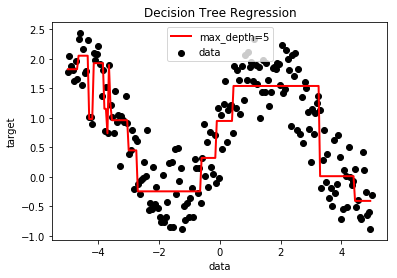

In [40]:
# 使用CART回归树模拟sin函数
np.random.seed(0)

X = np.linspace(-5, 5, 200)
y = np.sin(X)
y = y + np.random.rand(1, len(y)) * 1.5 # 加入噪声

X = X.reshape(-1, 1)
y = y.reshape(-1, 1)

cart_regressor = generate_cart_regressor(X, y, 1, 5)

X_train = np.arange(-5, 5, 0.05).reshape(-1, 1)
y_predict = np.zeros((X_train.shape[0], 1))

for i in range(X_train.shape[0]):
    y_predict[i, 0] = cart_regressor_inference(cart_regressor, X[i])

plt.figure()
plt.scatter(X, y,c="k", label="data")
plt.plot(X_train, y_predict, c="r", label="max_depth=5", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

下面不是实验内容，有兴趣可以了解下CART的剪枝。

## CART剪枝

CART剪枝算法由两步组成：首先从生成算法产生的决策树$T_0$底端开始不断剪枝，直到$T_0$的根结点，形成一个子树序列${T_0, T_1, \cdots, T_n}$；然后通过交叉验证法在独立的验证数据集上对子树序列进行测试，从中选择最优子树。

定义子树的损失函数为：
$$
C_{\alpha}(T) = C(T) + \alpha |T|
$$
其中$C(T)$表示对训练数据的预测误差（如基尼值），$|T|$为子树的叶子结点的个数。
对T的任意内部结点t，以t为单结点树的损失函数是：
$$
C_{\alpha}(t) = C(t) + \alpha
$$
以t为根结点的子树$T_t$的损失函数是：
$$
C_{\alpha}(T_t) = C(T_t) + \alpha |T_t|
$$

CART剪枝算法如下：

输入：CART算法生成的决策树$T_0$:  
输出：最优决策树$T_{\alpha}$：  
（1）设$k=0$，$T = T_0$  
（2）设$\alpha = +\infty$  
（3）自下而上地对各内部结点t计算$C(T_t)$，$|T_t|$以及
$$
g(t) = \frac{C(t) - C(T_t)}{|T_t| - 1} \\
\alpha = \min(\alpha, g(t))
$$
这里$T_t$表示以t为根结点的子树，$C(T_t)$是对训练数据的预测误差，$|T_t|$是$T_t$的叶结点个数。  
（4）对$g(t) = \alpha$的内部结点t进行剪枝，并对叶结点t以多数表决法决定其类，得到树T。  
（5）设$k = k+1$，$\alpha_k = \alpha$，$T_k = T$。  
（6）如果$T_k$不是由根结点及两个叶结点构成的树，则回到步骤（3）；否则令$T_k = T_n$。  
（7）采用交叉验证法在子树序列$T_0, T_1, \cdots, T_n$中选取最优子树$T_{\alpha}$。

算法的详细解释请看李航的《统计学习方法》的5.5.2部分内容。

回归树的剪枝算法与决策树的剪枝算法类似。我们同时实现CART分类树和回归树的剪枝算法。首先实现计算$C(t)$和$C(T_t)$的函数`compute_node_loss`和`compute_tree_loss`。

In [41]:
def compute_node_loss(node, tree_type):
    """
    计算C(t)的值
    参数：
        node：内部结点
        tree_type: 树的类型，"classifier": 决策树，"regressor": 回归树
    返回:
        C(t)的值
    """
    if tree_type == "classifier":
        m = sum(node.train_classes_num)
        return m * compute_gini(node.train_classes_num)
    if tree_type == "regressor":
        return np.sum(np.power(node.y - node.predict, 2))

In [42]:
def compute_tree_loss_and_leaf(root, tree_type):
    """
    计算C(T_t)的值和树的叶子结点个数
    参数：
        root: 树的根结点
        tree_type: 树的类型，"classifier": 决策树，"regressor": 回归树
    返回：
        C(T_t)的值和树的叶子结点个数
    """
    loss = 0
    leaf_node_num = 0
    node_list = [root]
    while len(node_list) != 0:
        node = node_list.pop(0)
        if tree_type == "classifier":
            if type(node) == InternalNode:
                node_list.extend(node.branch)
            else:
                leaf_node_num += 1
                loss += compute_gini(node.train_classes_num)
        if tree_type == "regressor":
            if node.type == "internal":
                node_list.append(node.left)
                node_list.append(node.right)
            else:
                leaf_node_num += 1
                loss += np.sum(np.power(node.y - node.predict, 2))
                
    return (loss, leaf_node_num)

实现`get_optimal_tree`，用于自下而上地对各内部结点t计算$C(T_t)$，$|T_t|$以及
$$
g(t) = \frac{C(t) - C(T_t)}{|T_t| - 1} \\
\alpha = \min(\alpha, g(t))
$$
这里$T_t$表示以t为根结点的子树，$C(T_t)$是对训练数据的预测误差，$|T_t|$是$T_t$的叶结点个数。

In [43]:
def get_optimal_tree(tree, p, alpha, tree_type):
    """
    对每个alpha区间，找到最优子树
    参数：
        tree: CART树
        p: 父结点
        alpha: 目前alpha的值
        tree_type: 树的类型，"classifier": 决策树，"regressor": 回归树
    返回：
        (alpha, p, t): 更新后的alpha值， t的父结点p， 选择的内部结点t
    """
    best_alpha = alpha
    best_p = None
    best_t = None
    if tree_type == "classifier":
        if type(tree.branch[0]) == InternalNode:
            sub_alpha, sub_p, sub_t = get_optimal_tree(tree.branch[0], tree, alpha, tree_type)
            if best_alpha > sub_alpha:
                best_alpha, best_p, best_t = sub_alpha, sub_p, sub_t
        if type(tree.branch[1]) == InternalNode:
            sub_alpha, sub_p, sub_t = get_optimal_tree(tree.branch[1], tree, alpha, tree_type)
            if best_alpha > sub_alpha:
                best_alpha, best_p, best_t = sub_alpha, sub_p, sub_t
        node_loss = compute_node_loss(tree, tree_type)
        tree_loss, num = compute_tree_loss_and_leaf(tree, tree_type)
        gt = (node_loss - tree_loss) / (num - 1)
        if gt < best_alpha:
            best_alpha, best_p, best_t = gt, p, tree
    
    if tree_type == "regressor":
        if tree.left.type == "internal":
            sub_alpha, sub_p, sub_t = get_optimal_tree(tree.left, tree, alpha, tree_type)
            if best_alpha > sub_alpha:
                best_alpha, best_p, best_t = sub_alpha, sub_p, sub_t
        if tree.right.type == "internal":
            sub_alpha, sub_p, sub_t = get_optimal_tree(tree.right, tree, alpha, tree_type)
            if best_alpha > sub_alpha:
                best_alpha, best_p, best_t = sub_alpha, sub_p, sub_t
        node_loss = compute_node_loss(tree, tree_type)
        tree_loss, num = compute_tree_loss_and_leaf(tree, tree_type)
        gt = (node_loss - tree_loss) / (num - 1)
        if gt < best_alpha:
            best_alpha, best_p, best_t = gt, p, tree
    
    return (best_alpha, best_p, best_t)

In [44]:
def pruning_cart(tree0, val_X, val_y, tree_type):
    """
    对CART树进行剪枝
    参数：
        tree0: CART树T_0
        val_X: 交叉验证集X
        val_y: 交叉验证集y
        tree_type: 树的类型，"classifier": 决策树，"regressor": 回归树
    返回：
        最优子树T
    """
    if tree_type == "classifier":
        if type(tree0) == LeafNode:
            return tree0
        if type(tree0.branch[0]) == LeafNode and type(tree0.branch[1]) == LeafNode:
            return tree0
    if tree_type == "regressor":
        if tree0.type == "leaf":
            return tree0
        if tree0.left.type == "leaf" and tree0.right.type == "leaf":
            return tree0
    
    T_list = [tree0]
    alpha_list = [0]
    while True:
        T = copy.deepcopy(T_list[-1])
        root = T
        alpha, p, best_t = get_optimal_tree(T, None, sys.maxsize, tree_type)
        # 裁剪t
        t = None
        if tree_type == "classifier":
            t = LeafNode()
            t.train_classes_num = best_t.train_classes_num
            t.val_classes_num = best_t.val_classes_num
            t.data_info = best_t.data_info
            t.classs_label = get_max_num_class(t.train_classes_num)
        if tree_type == "regressor":
            t = RNode()
            t.type = "leaf"
            t.y = best_t.y
            t.predict = best_t.predict
            
        alpha_list.append(alpha)
        # 根结点也可以是叶子结点
        if best_t == root:
            T_list.append(t)
            break
        else:
            if tree_type == "classifier":
                if p.branch[0] == best_t:
                    p.branch[0] = t
                if p.branch[1] == best_t:
                    p.branch[1] = t
            if tree_type == "regressor":
                if p.left == best_t:
                    p.left = t
                if p.right == best_t:
                    p.right = t
            T_list.append(T)

    # 采用交叉验证法在子树序列T_list中选取最优子树T
    best_T = None
    if tree_type == "classifier":        
        best_acc = 0
        for T in T_list:
            y_predict = []
            for i in range(len(val_X)):
                predict = cart_classifier_inference(T, val_X[i])
                y_predict.append(1 if predict == val_y[i] else 0)
            acc = np.mean(y_predict)
            if acc > best_acc:
                best_acc = acc
                best_T = T
    if tree_type == "regressor":
        best_loss = sys.maxsize
        for T in T_list:
            y_predict = []
            for i in range(len(val_X)):
                y_predict.append(cart_regressor_inference(T, val_X[i]))
            y_predict = np.array(y_predict).reshape(-1, 1)
            loss = np.mean(np.power(val_y - y_predict, 2))
            if loss < best_loss:
                best_loss = loss
                best_T = T
       
    return best_T

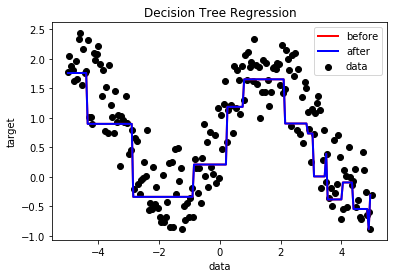

In [45]:
# 使用CART回归树模拟sin函数
np.random.seed(0)

X = np.linspace(-5, 5, 200)
y = np.sin(X)
y = y + np.random.rand(1, len(y)) * 1.5 # 加入噪声

X = X.reshape(-1, 1)
y = y.reshape(-1, 1)

np.random.seed(0)
indicate = np.random.rand(200) <= 0.7

X_train = X[indicate].reshape(-1, 1)
y_train = y[indicate].reshape(-1, 1)

X_val = X[~indicate].reshape(-1, 1)
y_val = y[~indicate].reshape(-1, 1)

regressor_before = generate_cart_regressor(X_train, y_train, 1, 5)

X_show = np.arange(-5, 5, 0.05).reshape(-1, 1)
y_predict_before = np.zeros((X_show.shape[0], 1))

for i in range(X_show.shape[0]):
    y_predict_before[i, 0] = cart_regressor_inference(regressor_before, X_show[i])

regressor_after = pruning_cart(regressor_before, X_val, y_val, "regressor")

y_predict_after = np.zeros((X_show.shape[0], 1))

for i in range(X_show.shape[0]):
    y_predict_after[i, 0] = cart_regressor_inference(regressor_before, X_show[i])

    
plt.figure()
plt.scatter(X, y,c="k", label="data")
plt.plot(X_show, y_predict_before, c="r", label="before", linewidth=2)
plt.plot(X_show, y_predict_before, c="b", label="after", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

In [46]:
# 分类树剪枝
m = len(data_set)
data_train = []
X_val = []
y_val = []
for i in range(int(m * 0.7)):
    data_train.append(data_set[i])
    
for i in range(int(m * 0.7), m):
    X_val.append(data_set[i][0:-1])
    y_val.append(data_set[i][-1])

classifier_before = generate_cart_classifier(data_train, data_info)
#print(json.dumps(eval(str(classifier_before)), sort_keys=True, indent=2))
classifier_after = pruning_cart(classifier_before, X_val, y_val, "classifier")
print(json.dumps(eval(str(classifier_before)), sort_keys=True, indent=2))

{
  "RW": {
    "1": {
      "LD": {
        "1": {
          "RD": {
            "1": {
              "LW": {
                "1": "B",
                "other": "L"
              }
            },
            "other": {
              "LW": {
                "4": {
                  "RD": {
                    "4": "B",
                    "other": {
                      "RD": {
                        "5": "R",
                        "other": "L"
                      }
                    }
                  }
                },
                "other": {
                  "RD": {
                    "2": {
                      "LW": {
                        "1": "R",
                        "other": {
                          "LW": {
                            "2": "B",
                            "other": "L"
                          }
                        }
                      }
                    },
                    "other": {
                      "LW": {
        